# Import

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxPH, DeepHit

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

In [3]:
df_raw = pd.read_csv('use.csv')
df_raw = pd.DataFrame(df_raw)
df_raw.head()

,Age,Year,Race,Grade,Pathology,T,N,M,Stage,Size,...,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA,duration,event
0,82,2015,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,27,...,6,Yes,No,No,Yes,7,7,7.2,50,1
1,69,2013,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,5,...,2,Yes,No,No,Yes,6,6,12.0,82,0
2,58,2011,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,18,...,3,Yes,No,No,Yes,7,7,5.7,107,0
3,69,2014,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,15,...,5,Yes,No,No,Yes,6,7,3.6,64,0
4,62,2014,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,19,...,6,Yes,No,No,Yes,8,9,17.2,62,0


In [4]:
# take out y
df_raw_y = df_raw[["duration","event"]]
df_raw_y.head()

,duration,event
0,50,1
1,82,0
2,107,0
3,64,0
4,62,0


In [5]:
# take out x
df_raw_x = df_raw.drop(["duration","event","Year"], axis=1)
df_raw_x.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Size,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
0,82,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,27,0,6,Yes,No,No,Yes,7,7,7.2
1,69,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,5,0,2,Yes,No,No,Yes,6,6,12.0
2,58,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,18,0,3,Yes,No,No,Yes,7,7,5.7
3,69,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,15,0,5,Yes,No,No,Yes,6,7,3.6
4,62,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,19,0,6,Yes,No,No,Yes,8,9,17.2


In [7]:
# transform the categorical variables
le = LabelEncoder()
cat_list = ["Race","Grade","Pathology","T","N","M","Stage","Surgery","Radiotherapy","Chemotherapy","History.Of.Malignancy"] #list of categorical variables
for cat in cat_list:
    df_raw_x[cat] = le.fit_transform(df_raw_x[cat])
df_raw_x.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Size,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
0,82,2,1,2,6,0,0,2,27,0,6,1,0,0,1,7,7,7.2
1,69,2,1,2,4,0,0,1,5,0,2,1,0,0,1,6,6,12.0
2,58,2,2,2,8,0,0,3,18,0,3,1,0,0,1,7,7,5.7
3,69,2,1,2,4,0,0,1,15,0,5,1,0,0,1,6,7,3.6
4,62,1,2,2,8,0,0,3,19,0,6,1,0,0,1,8,9,17.2


In [8]:
# split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=2022)
x_train.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Size,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
3837,74,2,1,2,6,0,0,2,10,0,2,1,0,0,0,6,6,7.5
11328,66,2,2,2,6,0,0,2,10,0,7,1,0,0,0,9,7,6.5
1871,62,1,1,2,6,0,0,2,10,0,2,1,0,0,0,7,6,26.5
7936,65,2,1,2,4,0,0,1,18,0,9,1,0,0,0,6,7,1.2
14856,61,2,2,2,9,0,0,3,22,0,6,1,1,0,0,8,7,27.0


In [9]:
# sign group info on the raw data 
df_raw.loc[x_train.index, "Group"] = "Train"
df_raw.loc[x_test.index, "Group"] = "Test"
df_raw.head()

,Age,Year,Race,Grade,Pathology,T,N,M,Stage,Size,...,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA,duration,event,Group
0,82,2015,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,27,...,Yes,No,No,Yes,7,7,7.2,50,1,Train
1,69,2013,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,5,...,Yes,No,No,Yes,6,6,12.0,82,0,Train
2,58,2011,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,18,...,Yes,No,No,Yes,7,7,5.7,107,0,Test
3,69,2014,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,15,...,Yes,No,No,Yes,6,7,3.6,64,0,Test
4,62,2014,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,19,...,Yes,No,No,Yes,8,9,17.2,62,0,Test


In [11]:
df_raw_x.columns

Index(['Age', 'Race', 'Grade', 'Pathology', 'T', 'N', 'M', 'Stage', 'Size',
       'Regional.nodes.positive', 'Regional.nodes.examined', 'Surgery',
       'Radiotherapy', 'Chemotherapy', 'History.Of.Malignancy', 'Gleason.C.',
       'Gleason.P.', 'PSA'],
      dtype='object')

# Conduct Net

In [12]:
cols_standardize = ["Age","Size","Regional.nodes.positive","Regional.nodes.examined","Gleason.C.","Gleason.P.","PSA"]
cols_leave = ["Race","Grade","Pathology","T","N","M","Stage","Surgery","Radiotherapy","Chemotherapy","History.Of.Malignancy"] 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(x_train).astype('float32')
x_test = x_mapper.transform(x_test).astype('float32')

In [13]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(y_train)
y_test = get_target(y_test)
#durations_test, events_test = get_target(y_test)
val = x_test, y_test

In [14]:
y_test

(array([ 94,  50, 111, ...,  80,  67,  96], dtype=int64),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int64))

In [51]:
in_features = x_train.shape[1]
num_nodes = [256,128,64,32,32,8]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
batch_size = 2048


net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 7.2801,	val_loss: 6.8786
1:	[0s / 0s],		train_loss: 7.1612,	val_loss: 6.8807
2:	[0s / 0s],		train_loss: 7.1255,	val_loss: 6.8733
3:	[0s / 0s],		train_loss: 7.0774,	val_loss: 6.8577
4:	[0s / 0s],		train_loss: 7.0716,	val_loss: 6.8527
5:	[0s / 0s],		train_loss: 7.0593,	val_loss: 6.8446
6:	[0s / 1s],		train_loss: 7.0475,	val_loss: 6.8351
7:	[0s / 1s],		train_loss: 7.0147,	val_loss: 6.8234
8:	[0s / 1s],		train_loss: 7.0202,	val_loss: 6.8145
9:	[0s / 1s],		train_loss: 7.0193,	val_loss: 6.8132
10:	[0s / 1s],		train_loss: 7.0027,	val_loss: 6.8164
11:	[0s / 1s],		train_loss: 7.0133,	val_loss: 6.8225
12:	[0s / 1s],		train_loss: 6.9925,	val_loss: 6.8238
13:	[0s / 1s],		train_loss: 6.9744,	val_loss: 6.8159
14:	[0s / 2s],		train_loss: 6.9789,	val_loss: 6.8130
15:	[0s / 2s],		train_loss: 6.9844,	val_loss: 6.8133
16:	[0s / 2s],		train_loss: 6.9745,	val_loss: 6.8157
17:	[0s / 2s],		train_loss: 6.9661,	val_loss: 6.8109
18:	[0s / 2s],		train_loss: 6.9647,	val_loss: 6.8083
19:

0.6928992044417494

<Figure size 864x864 with 0 Axes>

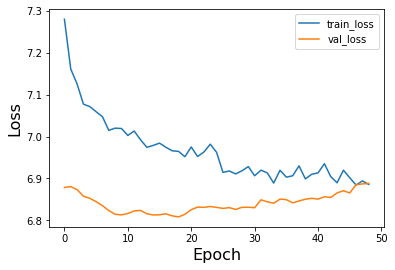

In [53]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model.compute_baseline_hazards() #baseline hazard
surv_cox = model.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, y_test[0], y_test[1], censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.04529319151373192

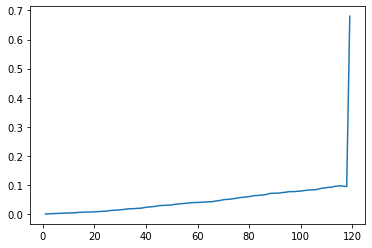

In [54]:
# integrated_brier_score at all
time_grid = np.linspace(y_test[0].min(), y_test[0].max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [55]:
# Internal c-index at  all
time_test0, status_test0 = y_train[0], y_train[1]
surv_cox0 = model.predict_surv_df(x_train) # survival of the train data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7180860127220675

# Bootstrap

In [71]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 500,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.7169206188338457
The C-index High 95% CI:0.7198365976213389
The C-index Low 95% CI:0.7140046400463526


In [72]:
# External
ex_tem = []
model.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 500,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))

Bootstrap Internal validation:
The C-index:0.6928333445387916
The C-index High 95% CI:0.6957864323844678
The C-index Low 95% CI:0.6898802566931155


# Prediction

In [61]:
time_test0, status_test0 = y_train[0], y_train[1]
surv_cox0 = model.predict_surv_df(x_train)
surv_cox0

,0,1,2,3,4,5,6,7,8,9,...,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258
duration,,,,,,,,,,,,,,,,,,,,,
1,0.999574,0.999590,0.999644,0.999845,0.999441,0.999507,0.999850,0.999864,0.999744,0.999132,...,0.999637,0.999877,0.999577,0.999817,0.999723,0.999616,0.998733,0.999723,0.999869,0.999833
2,0.999232,0.999262,0.999360,0.999722,0.998993,0.999113,0.999731,0.999755,0.999540,0.998438,...,0.999347,0.999779,0.999239,0.999671,0.999502,0.999309,0.997720,0.999502,0.999765,0.999699
3,0.998805,0.998852,0.999004,0.999567,0.998434,0.998619,0.999581,0.999619,0.999284,0.997569,...,0.998984,0.999656,0.998815,0.999487,0.999225,0.998925,0.996453,0.999225,0.999634,0.999531
4,0.998292,0.998358,0.998576,0.999381,0.997761,0.998026,0.999400,0.999455,0.998976,0.996526,...,0.998548,0.999508,0.998306,0.999267,0.998891,0.998463,0.994932,0.998891,0.999476,0.999330
5,0.997779,0.997865,0.998148,0.999194,0.997088,0.997433,0.999220,0.999291,0.998668,0.995483,...,0.998111,0.999360,0.997797,0.999046,0.998558,0.998001,0.993411,0.998558,0.999319,0.999128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.870285,0.874986,0.890630,0.950902,0.833456,0.851656,0.952415,0.956685,0.920112,0.753637,...,0.888569,0.960802,0.871277,0.942132,0.913790,0.882466,0.661676,0.913785,0.958314,0.946950
116,0.870285,0.874986,0.890630,0.950902,0.833456,0.851656,0.952415,0.956685,0.920112,0.753637,...,0.888569,0.960802,0.871277,0.942132,0.913790,0.882466,0.661676,0.913785,0.958314,0.946950
117,0.870285,0.874986,0.890630,0.950902,0.833456,0.851656,0.952415,0.956685,0.920112,0.753637,...,0.888569,0.960802,0.871277,0.942132,0.913790,0.882466,0.661676,0.913785,0.958314,0.946950


In [59]:
surv_cox0.to_csv("OS_prediction.csv")

In [60]:
df_raw.to_csv("use-grouped.csv")

# Save the model

In [76]:
model.save_model_weights("param.pt")
model.save_net("net.pt")

In [82]:
lz = torch.load('param.pt')
print(lz)

OrderedDict([('net.0.linear.weight', tensor([[ 0.5084,  0.0770,  0.2765,  ..., -0.5446,  0.7847,  0.1346],
        [-0.3524,  0.2936, -0.6827,  ..., -0.5769, -0.2373, -0.6214],
        [-0.2719,  0.7430, -0.1000,  ..., -0.3287,  0.0419,  0.1434],
        ...,
        [-0.2128, -0.1297, -0.2420,  ...,  0.1542,  0.5473,  0.4044],
        [ 0.4925, -0.0212,  0.2893,  ..., -0.0140,  0.1831, -0.3026],
        [ 0.0761,  0.1772,  0.3459,  ...,  0.0216,  0.1556, -0.0390]])), ('net.0.linear.bias', tensor([ 2.6987e-01,  2.0556e-01, -5.7349e-02,  1.6903e-01,  3.5251e-02,
         1.7626e-01, -1.4240e-01,  3.3873e-01,  9.6712e-02, -1.2207e-01,
        -1.3926e-01, -4.2459e-02, -4.4361e-02,  2.3401e-01, -2.9724e-02,
        -9.8933e-02, -2.1205e-01, -2.5670e-01,  2.2025e-01,  1.4044e-01,
        -6.0975e-03, -5.7686e-02, -8.3820e-02, -1.9470e-01, -2.3152e-01,
         7.3385e-02, -2.3343e-01, -6.5105e-02,  1.0070e-01,  3.0239e-02,
         6.3640e-05, -1.6332e-01,  1.0346e-01, -1.9992e-01,  6.0918